<a href="https://colab.research.google.com/github/artemisyang/LS_assignment1_Artemis/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install pyopencl mako
! pip install mpi4py

  Using cached https://files.pythonhosted.org/packages/ec/8f/bbd8de5ba566dd77e408d8136e2bab7fdf2b97ce06cab830ba8b50a2f588/mpi4py-3.0.3.tar.gz
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074431 sha256=207768c2152e6cc17178dcf979087385644a9b0d607945328bbe2f5ece27c72e
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [0]:
import numpy as np
import queue
import time
import scipy.stats as sts
from sklearn.model_selection import GridSearchCV, KFold
# Set model parameters

t0 = time.time()

rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
# Set simulation parameters, draw all idiosyncratic random shocks,
# and create empty containers
S = 5 # Set the number of lives to simulate
T = int(10) # Set the number of periods for each simulation
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
#print(eps_mat)

z_mat = np.zeros((T, S))
#z_mat[0, :] = z_0

for s_ind in range(S):
    z_tm1 = z_0
    #print(z_tm1)
    for t_ind in range(T):
        e_t = eps_mat[t_ind, s_ind]
        #print(e_t)
        z_t = rho * z_tm1 + (1 - rho) * mu + e_t
        #print(z_t)
        z_mat[t_ind, s_ind] = z_t
        #print(z_mat)
        z_tm1 = z_t
        #print(z_tm1)
#print(z_mat)

final_time = time.time()
time_elapsed = final_time - t0

# Print simulation results
print("Simulated %d lifetimes in: %f seconds"
                % (S, time_elapsed)) 

Simulated 5 lifetimes in: 0.005003 seconds


1.(a) The code from files that I ran on Midway RCC are attached. The plot is for 1-100 CPU cores.

In [0]:
# 1.(a) code from q1.sbatch file

#!/bin/bash

#SBATCH --job-name=q1
#SBATCH --partition=broadwl
#SBATCH --constraint=fdr
#SBATCH --ntasks=150
#SBATCH --output=q1.out

# Load the default mpi4py/Anaconda module.
 module load mpi4py/3.0.1a0_py3
 
# Run the python program with mpirun, using & to run jobs at the same time
  for i in {1..100}
  do
    mpirun -n $i python ./health_index.py
  done
 
# Wait until all simultaneous mpiruns are done
 wait

In [0]:
# 1.(a) code from health_index.py file

from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.stats as sts
    
def sim_health_index():

    # Get rank of process and overall size of communicator:
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    # Start time:
    t0 = time.time()
   
    # Set model parameters
    rho = 0.5
    mu = 3.0
    sigma = 1.0
    z_0 = mu

    # Set simulation parameters
    S = 1000 # Set the number of lives to simulate
    T = int(4160) # Set the number of periods for each simulation

    # Evenly distribute number of simulation runs across processes
    N = int(S/size)

    # Draw all idiosyncratic random shocks and create empty containers
    np.random.seed(25)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, N))
    z_mat = np.zeros((T, N))
    z_mat[0, :] = z_0

    for s_ind in range(N):
        z_tm1 = z_0
        for t_ind in range(T):
            e_t = eps_mat[t_ind, s_ind]
            z_t = rho * z_tm1 + (1 - rho) * mu + e_t
            z_mat[t_ind, s_ind] = z_t
            z_tm1 = z_t

  # Gather all simulation arrays to buffer on rank 0
    z_mat_all = None
    if rank == 0:
       z_mat_all = np.empty([T, int(N*size)], dtype = 'float')
    comm.Gather(sendbuf=z_mat, recvbuf=z_mat_all, root=0)
    #comm.gather(z_mat, root=0)
     
  # Print simulation results on rank 0
    if rank == 0:
     # Calculate time elapsed
       time_elapsed = time.time() - t0
     # Print(time_elapsed)
       print("Simulated lifetimes in: %f seconds on %d MPI processes"
                % (time_elapsed, size))     
   
    return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

Saving q1.csv to q1 (15).csv


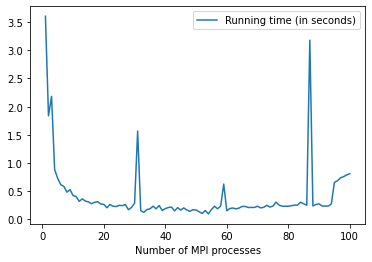

In [22]:
# 1.(a) plot

import pandas as pd
from google.colab import files
uploaded = files.upload()
import matplotlib.pyplot as plt

df = pd.read_csv("q1.csv", names=["Number of MPI processes", "Running time (in seconds)"])
df.plot(x="Number of MPI processes",y="Running time (in seconds)")


1.(b) The speedup is not linear because

2.(a) Using the elementwise kernel, it takes 1.03 seconds to run. Using the scan kernel, it only takes 0.56 seconds to run. However, there is some unknown calculation error in the scan kernel, so it doesn't return the correct values. Therefore I will still use the elementwise kernel.
(b) Compared with the mpi4py implementation, the PyOpenCL implementation costs very similar amount of time.

In [0]:
#2.(a) with elementwise kernel

import pyopencl as cl
import numpy as np
import pyopencl.array as cl_array
import pyopencl.clrandom as clrand
import pyopencl.tools as cltools
from pyopencl.elementwise import ElementwiseKernel
import matplotlib.pyplot as plt
import time
import scipy.stats as sts

def sim_health_index():

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  rho = 0.5
  mu = 3.0
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  init_np = np.zeros(S).astype(np.float32) + mu
  epsm_np = sts.norm.rvs(loc=0,scale=1.0,size=T*S).astype(np.float32)

  init_g = cl.array.to_device(queue, init_np)
  epsm_g = cl.array.to_device(queue, epsm_np)
  
  # GPU: Define Elementwise Kernel
  prefix_sum = ElementwiseKernel(ctx,
                                 "float *a_g, float *b_g, float *res_g, float rho, float mu",
                                 "res_g[i] = rho * a_g[i]+(1-rho)*mu + b_g[i]")
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(epsm_g)

  # Enqueue and Run Elementwise Kernel
  prefix_sum(init_g, epsm_g[:S], dev_result[:S], rho, mu)
  [prefix_sum(dev_result[S*(i-1):S*i], epsm_g[S*i:S*(i+1)],
              dev_result[S*i:S*(i+1)], rho, mu) for i in range(1,T)]

  # Get results back on CPU
  z_all = dev_result.get().reshape(T,S)

# Print simulation results
  print(z_all)

  final_time = time.time()
  time_elapsed = final_time - t0
  print("Simulated %d lifetimes in: %f seconds"
               % (S, time_elapsed)) 

  return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

[[3.2282732  4.0268903  2.1604152  ... 3.5980616  4.2172623  4.2740126 ]
 [2.7241552  2.7610037  1.8453364  ... 4.562945   4.1576777  2.4020617 ]
 [0.88323987 3.602325   1.863601   ... 3.6887615  3.2543025  3.5586102 ]
 ...
 [5.7436695  2.7490346  3.707395   ... 1.8711723  1.6462877  2.4367635 ]
 [5.444686   3.167647   4.440064   ... 2.866872   3.2936373  2.6143126 ]
 [3.721859   4.119889   4.6702805  ... 2.063307   3.2129734  2.634847  ]]
Simulated 1000 lifetimes in: 1.025692 seconds


In [0]:
# 2.(a) with scan kernel
import numpy as np 
import pyopencl as cl
import pyopencl.array as cl_array
import pyopencl.clrandom as clrand
import pyopencl.tools as cltools
from pyopencl.scan import GenericScanKernel
import matplotlib.pyplot as plt
import time
import scipy.stats as sts

def sim_health_index():

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  rand_gen = clrand.PhiloxGenerator(ctx)
  ran = rand_gen.normal(queue, (S*T), np.float32, mu=0, sigma=1)
  #print(ran)

  # Change the value for the first row to account for the initial value of z_t
  for z in range(S):
    z = z * T - T
    ran[z] = ran[z] + 3
  
  # Establish boundaries for each simulated 
  seg_boundaries = [1] + [0] * (T - 1) 
  seg_boundaries = np.array(seg_boundaries, dtype=np.uint8)
  #print(seg_boundaries)
  seg_boundary_flags = np.tile(seg_boundaries, int(S))
  seg_boundary_flags = cl_array.to_device(queue, seg_boundary_flags)
  #print(seg_boundary_flags)
  
  # GPU: Define Segmented Scan Kernel
  prefix_sum = GenericScanKernel(ctx, np.float32,
               arguments="__global float *ary, __global char *segflags, "
                   "__global float *out",
               input_expr="ary[i]",
               scan_expr="across_seg_boundary ? b : (b+a*0.5+1.5)", neutral="0",
               is_segment_start_expr="segflags[i]",
               output_statement="out[i] = item",
               options=[])
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(ran)

  # Enqueue and Run Scan Kernel
  prefix_sum(ran, seg_boundary_flags, dev_result)

  # Get results back on CPU
  z_all = (dev_result.get()
                     .reshape(S, T)
                     .transpose()
                         )

# Print simulation results
  print(z_all)

  final_time = time.time()
  time_elapsed = final_time - t0
  print("Simulated %d lifetimes in: %f seconds"
                % (S, time_elapsed)) 

  return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

[[ 1.7603674   1.3107433   3.5322912  ...  2.155868    2.7883685
   3.4775534 ]
 [ 3.739502    1.0686312   1.7670852  ...  2.6313999   2.5557666
   2.2458172 ]
 [ 2.4264278   1.2312961   3.9093     ...  0.98635244  2.1175416
   4.247703  ]
 ...
 [55.848923    8.316638   56.03035    ... 56.417202   45.23037
  56.336647  ]
 [57.62812     7.7891817  56.998714   ... 57.708862   44.673553
  55.75264   ]
 [56.930126    8.129516   58.808624   ... 57.86271    44.700035
  53.02154   ]]
Simulated 1000 lifetimes in: 0.563026 seconds


In [0]:
! mpirun --allow-run-as-root -n 5 python q3a.py

3.(a) With 20 CPU cores, the running time is 1290.3 seconds. The code from files that I ran on Midway RCC are attached:

In [0]:
# 3.(a) code from q3a.sbatch file

#!/bin/bash

#SBATCH --job-name=q3
#SBATCH --partition=broadwl
#SBATCH --constraint=fdr
#SBATCH --mem-per-cpu=2G

# Load the default mpi4py/Anaconda module.
 module load mpi4py/3.0.1a0_py3
 
# Run the python program with mpirun, using & to run jobs at the same time
 
 mpirun -n 20 python ./q3a.py

In [0]:
# 3.(a) code from q3a.py file

from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.stats as sts
    
def sim_health_index():

 # Start time
    t0 = time.time()
    
    # Run the health simulation program
    rho_array = np.linspace(-0.95,0.95,200)
    avg =[]
    
    for r in rho_array:
    
        # Get rank of process and overall size of communicator:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()
   
        # Set model parameters
        rho = r
        mu = 3.0
        sigma = 1.0
        z_0 = mu

        # Set simulation parameters
        S = 1000 # Set the number of lives to simulate
        T = int(4160) # Set the number of periods for each simulation

        # Evenly distribute number of simulation runs across processes
        N = int(S/size)

        # Draw all idiosyncratic random shocks and create empty containers
        eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, N))
        z_mat = np.zeros((T, N))
        z_mat[0, :] = z_0
    
        # Create an array to store the index for first negative z_t
        neg_index = np.full(N,fill_value = T+1)

        # Create the health index matrix
        for s_ind in range(N):
            z_tm1 = z_0
            for t_ind in range(T):
                e_t = eps_mat[t_ind, s_ind]
                z_t = rho * z_tm1 + (1 - rho) * mu + e_t
                z_mat[t_ind, s_ind] = z_t
                z_tm1 = z_t
                if z_tm1<0:
                  if neg_index[s_ind] == T+1:
                     neg_index[s_ind] = t_ind+1

        # Gather all simulation arrays to buffer on rank 0
        neg_all = comm.gather(neg_index, root = 0)
     
        # Return average number of periods on rank 0
        if rank == 0:
           mean = np.mean(neg_all)
           avg.append(mean)
           
    if rank == 0:
        
       # Get optimal rho value
       ind = avg.index(max(avg))
       opt = rho_array[ind]
       max_avg = max(avg)
    
       # End time
       time_elapsed = time.time() - t0

       # Print simulation results
       print("Simulated in %f seconds, Optimal rho value = %f, Average periods = %f"
                % (time_elapsed, opt, max_avg)) 
       print(rho_array)
       print(avg)

def main():
   sim_health_index()
          
if __name__ == '__main__':
    main()

3.(b) 
Using GPU to run the same program, the optimal $\rho$ value is 0.033417 and the average number of periods is 755.71. Computation time becomes 1471 seconds. 

In [0]:
# 3.(b) grid search with OpenCL

import pyopencl as cl
import pyopencl.array as cl_array
import pyopencl.clrandom as clrand
import pyopencl.tools as cltools
from pyopencl.elementwise import ElementwiseKernel
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.stats as sts

def sim_health_index(r):

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  rho = r
  mu = 3.0
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  init_np = np.zeros(S).astype(np.float32) + mu
  epsm_np = sts.norm.rvs(loc=0,scale=1.0,size=T*S).astype(np.float32)

  init_g = cl.array.to_device(queue, init_np)
  epsm_g = cl.array.to_device(queue, epsm_np)
  
  # GPU: Define Segmented Elementwise Kernel
  prefix_sum = ElementwiseKernel(ctx,
                                 "float *a_g, float *b_g, float *res_g, float rho, float mu",
                                 "res_g[i] = rho * a_g[i]+(1-rho)*mu + b_g[i]")
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(epsm_g)

  # Enqueue and Run Elementwise Kernel
  prefix_sum(init_g, epsm_g[:S], dev_result[:S], rho, mu)
  [prefix_sum(dev_result[S*(i-1):S*i], epsm_g[S*i:S*(i+1)],
              dev_result[S*i:S*(i+1)], rho, mu) for i in range(1,T)]

  # Get results back on CPU
  z_all = dev_result.get().reshape(T,S)

  # Create an array to store the index for first negative z_t
  neg_index = np.full(S,fill_value = T+1)

  # Print simulation results
  for s in range(S):
    for t in range(T):
      if z_all[t,s] < 0:
        if neg_index[s] == T+1:
           neg_index[s] = t+1
  mean = np.mean(neg_index)
  return mean

def main():
    # Start time
    t0 = time.time()
    
    # Run the health simulation program
    rho_array = np.linspace(-0.95,0.95,200)
    avg =[]
    for r in rho_array:
        avg.append(sim_health_index(r))

    # Get optimal rho value
    ind = avg.index(max(avg))
    opt = rho_array[ind]
    max_avg = max(avg)
    
    # End time
    time_elapsed = time.time() - t0

    # Print simulation results
    print("Simulated in %f seconds, Optimal rho value = %f, Average periods = %f"
                % (time_elapsed, opt, max_avg)) 
  
if __name__ == '__main__':
    main()

Simulated in 1470.674404 seconds, Optimal rho value = 0.033417, Average periods = 755.710000


3.(c) I use the results from the MPI implementation for the plot. The plot indicates that rho values close to 0 tend to have larger average periods to negative health index.

Saving q3c.csv to q3c (1).csv


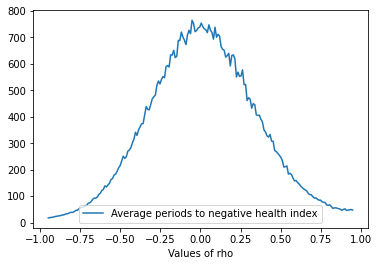

In [28]:
# 3.(c) plot

import pandas as pd
from google.colab import files
uploaded = files.upload()
import matplotlib.pyplot as plt

df2 = pd.read_csv("q3c.csv", names=["Values of rho", "Average periods to negative health index"])
df2.plot(x="Values of rho",y="Average periods to negative health index")

3.(d) From the MPI implementation in 3(a), the optimal $\rho$ value is -0.052513, and the corresponding average periods is 764.991. From the GPU implementation in 3(b), the optimal $\rho$ value is 0.033417, and the corresponding average periods is 755.71. The results are different but very close.